# Imports

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, CuDNNLSTM
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import copy

# Global Variables

In [2]:
MAX_INITIAL_POSITION = 0.25
MAX_INITIAL_VELOCITY = 0.25
MAX_INITIAL_ACCELERATION = 0.25
TIME_STEPS = 100
SAMPLE_SIZE = 10000
EPOCHS = 10
DT = 0.1

# Classes

In [3]:
class Particle:
    def __str__(self):
        return "Position: %s, Velocity: %s, Accleration: %s" % (self.position, self.velocity, self.acceleration)
    
    def __repr__(self):
        return "Position: %s, Velocity: %s, Accleration: %s" % (self.position, self.velocity, self.acceleration)
    
    def __init__(self):
        self.position = np.array([np.random.sample()*2-1,np.random.sample()*2-1]) * MAX_INITIAL_POSITION # Position X, Y
        self.velocity = np.array([np.random.sample()*2-1,np.random.sample()*2-1]) * MAX_INITIAL_VELOCITY # Velocity X, Y
        self.acceleration = np.array([0,0]) # np.array([np.random.sample()*2-1,np.random.sample()*2-1]) * MAX_INITIAL_ACCELERATION # Acceleration X, Y
        
    def apply_physics(self,dt):
        nextParticle = copy.deepcopy(self) # Copy to retain initial values
        nextParticle.position += self.velocity * dt
        nextParticle.velocity += self.acceleration * dt
        return nextParticle
    
    def apply_random_acceleration(self):
        self.acceleration = np.array([np.random.sample()*2-1,np.random.sample()*2-1]) * MAX_INITIAL_ACCELERATION # Acceleration X, Y
        
    def apply_harmonic_acceleration(self, time):
        self.acceleration = np.array([np.cos(time), np.sin(time)]) * MAX_INITIAL_ACCELERATION
        
    def apply_differential_equation(self, time):
        self.velocity = np.array([-self.position[1]-0.5*self.position[0], np.sin(self.position[0])])
    
    def as_list(self):
        return [self.position[0],self.position[1],self.velocity[0], self.velocity[1]], [self.acceleration[0], self.acceleration[1]]
    
    def physics_as_list(self,dt):
        n = self.apply_physics(dt)
        return [n.position[0], n.position[1], n.velocity[0], n.velocity[1]]

In [4]:
class RNN:
    def __str__(self):
        self.model.summary()
        return ""
    
    def __repr__(self):
        self.model.summary()
        return ""
    
    def __init__(self, input_size, time_steps, output_size, dropout=0.4):
        self.model = self.generate_model(input_size, output_size, time_steps, dropout)
        
    def generate_model(self, input_size, output_size, time_steps, dropout):
        initial_parameters = Input((1,input_size[0]))
        applied_parameters = Input((time_steps,input_size[1]))
        
        _, state_h, state_c = CuDNNLSTM(64, return_state=True)(applied_parameters)
        
        states = [state_h, state_c]
        
        lstm_output = CuDNNLSTM(64)(initial_parameters, initial_state=states)
        
        output_layer = Dense(output_size*time_steps, activation='tanh')(lstm_output)
        
        model = Model([initial_parameters,applied_parameters], output_layer)
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
        return model
    def train(self, input_data, output_data, batch_size=32, epochs=10):
        self.model.fit(input_data, output_data, batch_size=batch_size, epochs=epochs)
    def predict(self,input_data):
        return self.model.predict(input_data)

# Training Data

In [5]:
def get_samples(dt, sample_size, time_steps):
    objects = []
    applied = []
    steps = []
    for _ in range(sample_size):
        particle = Particle()
        obj, _ = particle.as_list()
        apply = []
        step = []
        objects.append(obj)
        for t in range(time_steps):
            particle.apply_differential_equation(t*dt)
            _, app = particle.as_list()
            apply.append(app)
            step.append(particle.physics_as_list(dt))
            particle = particle.apply_physics(dt)
        steps.append(step)
        applied.append(apply)
    return np.array(objects).reshape(-1,1,4), np.array(applied).reshape(-1,time_steps,2), np.array(steps).reshape(-1,time_steps*4)

# Training

In [6]:
rnn = RNN(input_size=[4,2], output_size=4, time_steps=TIME_STEPS)
objects, applied, steps = get_samples(dt=DT, sample_size=SAMPLE_SIZE, time_steps=TIME_STEPS)
rnn.train([objects, applied], steps, epochs=EPOCHS)

Epoch 1/10
10000/10000 [==============================] - 18s 2ms/step - loss: 0.0014 - acc: 0.3031
Epoch 2/10
10000/10000 [==============================] - 9s 878us/step - loss: 8.4761e-07 - acc: 0.6878
Epoch 3/10
10000/10000 [==============================] - 9s 877us/step - loss: 4.4186e-07 - acc: 0.7883
Epoch 4/10
10000/10000 [==============================] - 9s 878us/step - loss: 4.2747e-07 - acc: 0.8531
Epoch 5/10
10000/10000 [==============================] - 9s 875us/step - loss: 3.6706e-07 - acc: 0.8914
Epoch 6/10
10000/10000 [==============================] - 9s 873us/step - loss: 3.5873e-07 - acc: 0.9047
Epoch 7/10
10000/10000 [==============================] - 9s 876us/step - loss: 3.8729e-07 - acc: 0.9093
Epoch 8/10
10000/10000 [==============================] - 9s 877us/step - loss: 3.7373e-07 - acc: 0.9146
Epoch 9/10
10000/10000 [==============================] - 9s 874us/step - loss: 3.6022e-07 - acc: 0.9138
Epoch 10/10
10000/10000 [==============================] - 9

In [7]:
# Shouldn't be using training data for predictions... Too lazy...
predictions = rnn.predict([np.array(objects[:10]).reshape(-1,1,4), np.array(applied[:10]).reshape(-1,TIME_STEPS,2)]).reshape(-1,TIME_STEPS,4)

Solving $\frac{dx}{dt}=-y-0.5x, \frac{dy}{dt}=sin(x)$

<IPython.core.display.Javascript object>


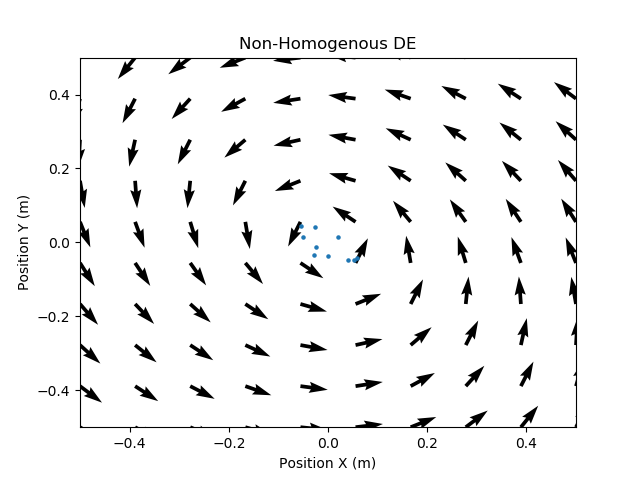

In [19]:
%matplotlib notebook

fig, ax = plt.subplots()
ax.set(xlim=(-0.5, 0.5), ylim=(-0.5,0.5))
X = np.linspace(-0.5, 0.5, 10)
Y = np.linspace(-0.5, 0.5, 10)

for x in X:
    for y in Y:
        plt.quiver(x, y, -y-0.5*x, np.sin(x))

scat = plt.scatter([], [], s=5)

def update(frame):
    P= []
    
    for path in predictions:
        P.append([path[frame][0], path[frame][1]])
    
    scat.set_offsets(tuple(P))
    
    return scat,

ani = FuncAnimation(fig, update, frames=TIME_STEPS, blit=True, interval=50)
plt.title("Non-Homogenous DE")
plt.xlabel("Position X (m)")
plt.ylabel("Position Y (m)")
#ani.save("DE.mp4")
plt.show()

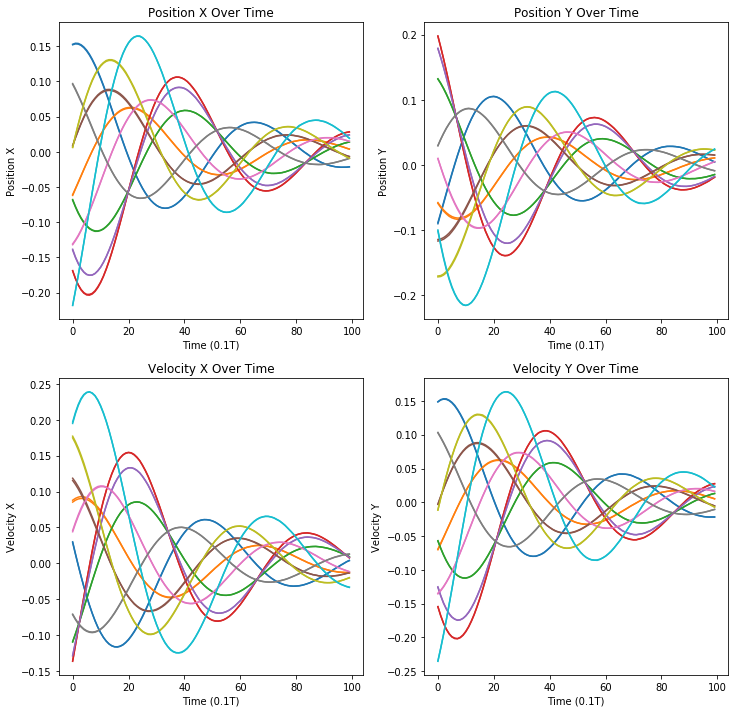

In [8]:
plt.figure(figsize=(12,12))

plt.subplot(2,2,1)
plt.title("Position X Over Time")
plt.xlabel("Time (0.1T)")
plt.ylabel("Position X")
for pred in predictions:
    plt.plot([p[0] for p in pred])
for step in steps.reshape(-1,TIME_STEPS,4)[:10]:
    plt.plot([p[0] for p in step])

plt.subplot(2,2,2)
plt.title("Position Y Over Time")
plt.xlabel("Time (0.1T)")
plt.ylabel("Position Y")
for pred in predictions:
    plt.plot([p[1] for p in pred])
for step in steps.reshape(-1,TIME_STEPS,4)[:10]:
    plt.plot([p[1] for p in step])
    
plt.subplot(2,2,3)
plt.title("Velocity X Over Time")
plt.xlabel("Time (0.1T)")
plt.ylabel("Velocity X")
for pred in predictions:
    plt.plot([p[2] for p in pred])
for step in steps.reshape(-1,TIME_STEPS,4)[:10]:
    plt.plot([p[2] for p in step])
    
plt.subplot(2,2,4)
plt.title("Velocity Y Over Time")
plt.xlabel("Time (0.1T)")
plt.ylabel("Velocity Y")
for pred in predictions:
    plt.plot([p[3] for p in pred])
for step in steps.reshape(-1,TIME_STEPS,4)[:10]:
    plt.plot([p[3] for p in step])

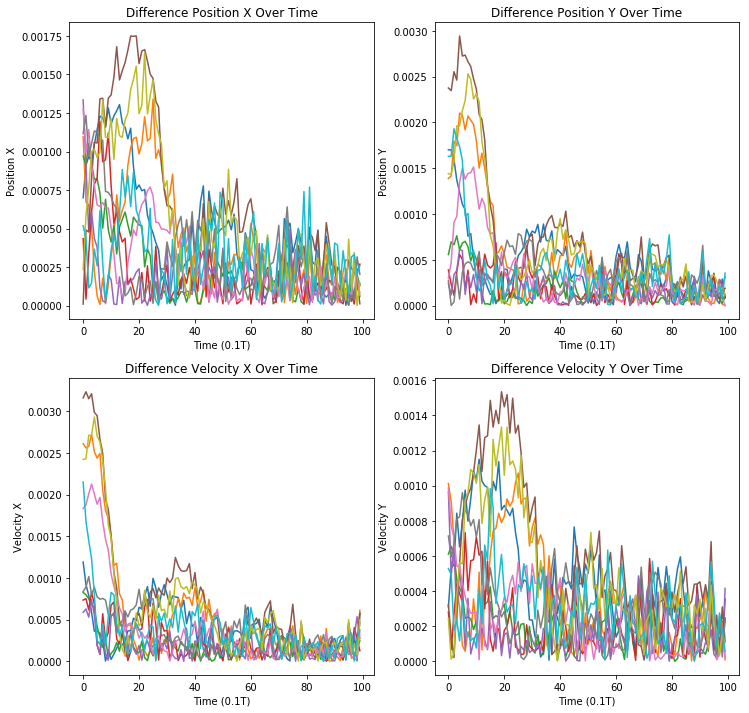

In [13]:
plt.figure(figsize=(12,12))

difference = abs(predictions - steps.reshape(-1,TIME_STEPS,4)[:10])

plt.subplot(2,2,1)
plt.title("Difference Position X Over Time")
plt.xlabel("Time (0.1T)")
plt.ylabel("Position X")
for pred in difference:
    plt.plot([p[0] for p in pred])

plt.subplot(2,2,2)
plt.title("Difference Position Y Over Time")
plt.xlabel("Time (0.1T)")
plt.ylabel("Position Y")
for pred in difference:
    plt.plot([p[1] for p in pred])
    
plt.subplot(2,2,3)
plt.title("Difference Velocity X Over Time")
plt.xlabel("Time (0.1T)")
plt.ylabel("Velocity X")
for pred in difference:
    plt.plot([p[2] for p in pred])
    
plt.subplot(2,2,4)
plt.title("Difference Velocity Y Over Time")
plt.xlabel("Time (0.1T)")
plt.ylabel("Velocity Y")
for pred in difference:
    plt.plot([p[3] for p in pred])